In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
clean_data = pd.read_csv('../datasets/cleaned_loan_data.csv')
clean_data.head()

,loan_amnt,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,...,open_acc,pub_rec,total_pymnt,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,long_term,employment_verified,time_to_delinq
0,2500.0,13.98,85.42,4 years,RENT,20004.0,2010-07-01,Paid,other,19.86,...,7.0,0.0,3075.291779,2500.00,575.29,2013-07-01,90.85,0,0,NaN
1,5000.0,15.95,175.67,4 years,RENT,59000.0,2010-06-01,Charged Off,debt_consolidation,19.57,...,7.0,0.0,2948.760000,1909.02,873.81,2011-11-01,175.67,0,0,518.0
2,7000.0,9.91,225.58,10+ years,MORTGAGE,53796.0,2011-09-01,Paid,other,10.80,...,7.0,0.0,8082.391880,7000.00,1082.39,2014-03-01,1550.27,0,0,NaN
3,2000.0,5.42,60.32,10+ years,RENT,30000.0,2011-09-01,Paid,debt_consolidation,3.60,...,7.0,0.0,2161.663244,2000.00,161.66,2014-02-01,53.12,0,0,NaN
4,3600.0,10.25,116.59,10+ years,MORTGAGE,675048.0,2010-04-01,Paid,other,1.55,...,8.0,0.0,4206.031191,3600.00,606.03,2013-05-01,146.75,0,0,NaN


Exploremos nuestras características para ver si existen relaciones que puedan explicar el abandono.

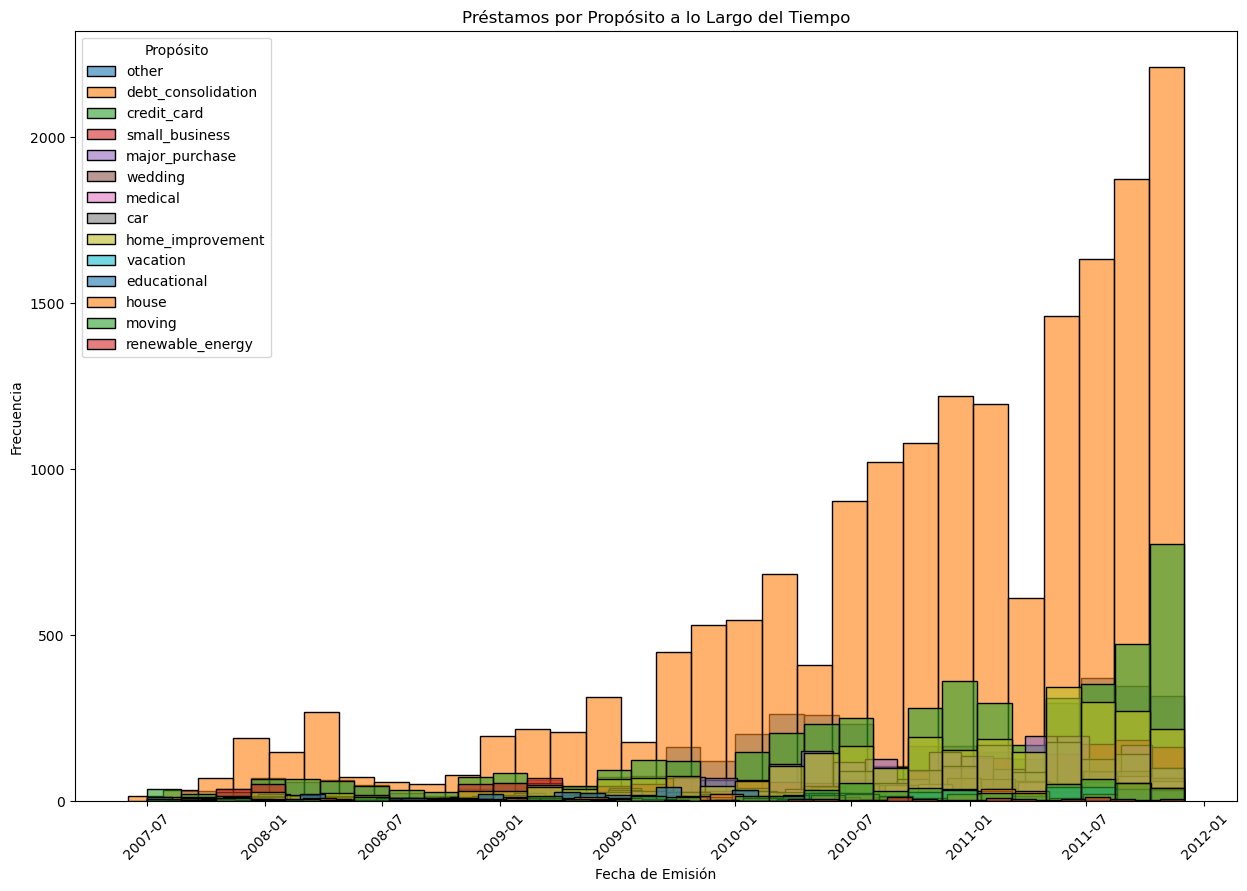

In [47]:
clean_data['issue_d'] = pd.to_datetime(clean_data['issue_d'])

loan_purposes = clean_data['purpose'].unique()

plt.figure(figsize=(15, 10))
for purpose in loan_purposes:
    subset = clean_data[clean_data['purpose'] == purpose]
    sns.histplot(subset['issue_d'], bins=30, kde=False, label=purpose, alpha=0.6)

plt.title('Préstamos por Propósito a lo Largo del Tiempo')
plt.xlabel('Fecha de Emisión')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Propósito')
plt.show()

A lo largo del tiempo, el número de préstamos emitidos incrementa. Dividiéndolo por categorías, no parece ser que el incremento depende del propósito del préstamo.

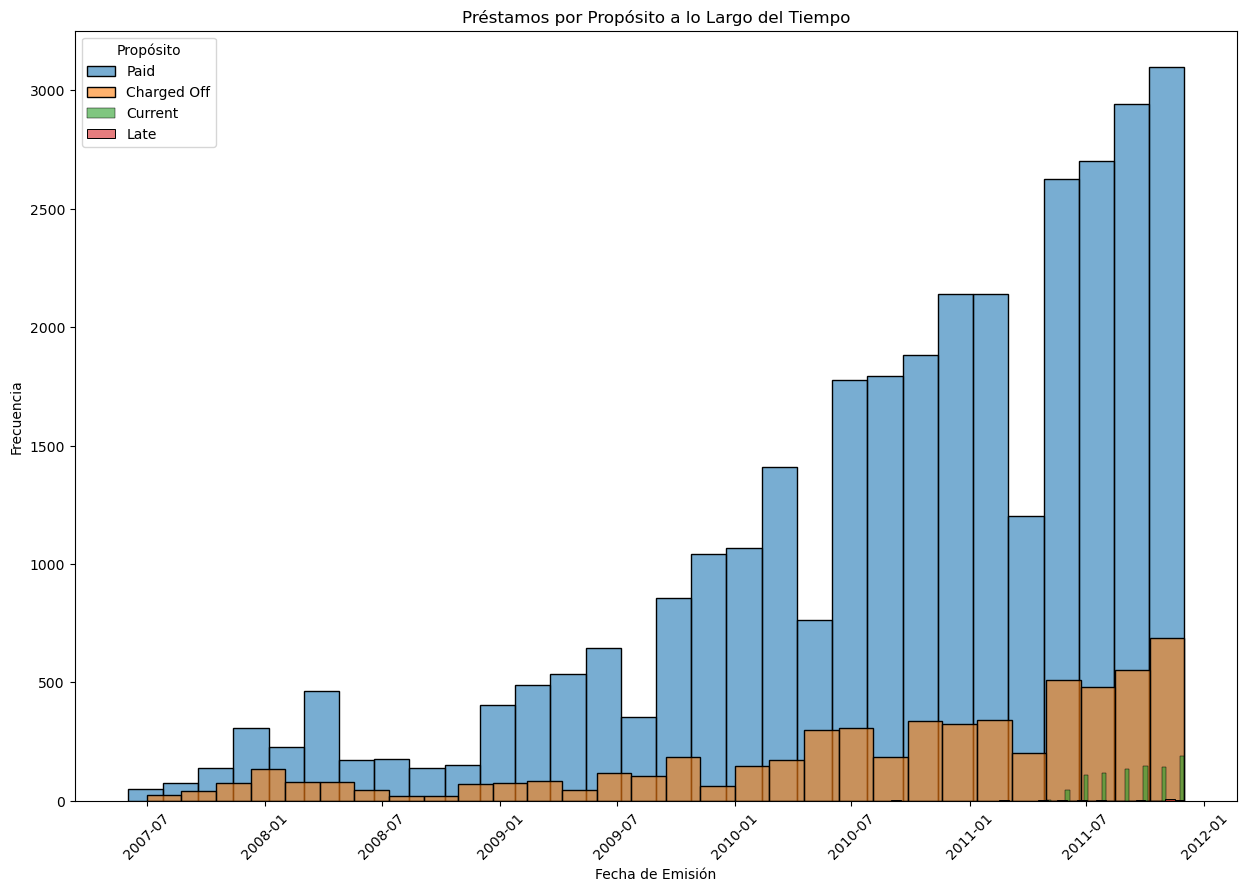

In [ ]:
clean_data['issue_d'] = pd.to_datetime(clean_data['issue_d'])

loan_status = clean_data['loan_status'].unique()

plt.figure(figsize=(15, 10))
for status in loan_status:
    subset = clean_data[clean_data['loan_status'] == status]
    sns.histplot(subset['issue_d'], bins=30, kde=False, label=status, alpha=0.6)

plt.title('Préstamos por Propósito a lo Largo del Tiempo')
plt.xlabel('Fecha de Emisión')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Propósito')
plt.show()

Tampoco parece que el incremento de prestamos conduzca a un incremento inesperado de prestamos abandonados.

Pero lo que se puede ver es que los valores 'Current' y 'Late' representan una cantidad minúscula de nuestro dataset. Vamos a removerlos con el fin de reemplazar la columna con una columna 'abandonment', que será True para Charged Off, False para Paid. Este será nuestro Target.

In [ ]:
clean_data = clean_data[clean_data['loan_status'].isin(['Paid', 'Charged Off'])]
clean_data['abandonment'] = clean_data['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

clean_data = clean_data.drop(columns=['loan_status'])

print(clean_data.head())

   loan_amnt  int_rate  installment emp_length home_ownership  annual_inc  \
0     2500.0     13.98        85.42    4 years           RENT     20004.0   
1     5000.0     15.95       175.67    4 years           RENT     59000.0   
2     7000.0      9.91       225.58  10+ years       MORTGAGE     53796.0   
3     2000.0      5.42        60.32  10+ years           RENT     30000.0   
4     3600.0     10.25       116.59  10+ years       MORTGAGE    675048.0   

     issue_d             purpose    dti  delinq_2yrs  ...  pub_rec  \
0 2010-07-01               other  19.86          0.0  ...      0.0   
1 2010-06-01  debt_consolidation  19.57          0.0  ...      0.0   
2 2011-09-01               other  10.80          3.0  ...      0.0   
3 2011-09-01  debt_consolidation   3.60          0.0  ...      0.0   
4 2010-04-01               other   1.55          0.0  ...      0.0   

   total_pymnt  total_rec_prncp  total_rec_int  last_pymnt_d  last_pymnt_amnt  \
0  3075.291779          2500.00    

Veamos como influye emp_length en el abandono.

emp_length
0            22.779519
1 year       15.305164
10+ years    16.629848
2 years      13.831554
3 years      14.872192
4 years      14.634146
5 years      15.253144
6 years      15.142857
7 years      15.827774
8 years      15.127841
9 years      13.760684
< 1 year     15.055432
Name: abandonment, dtype: float64


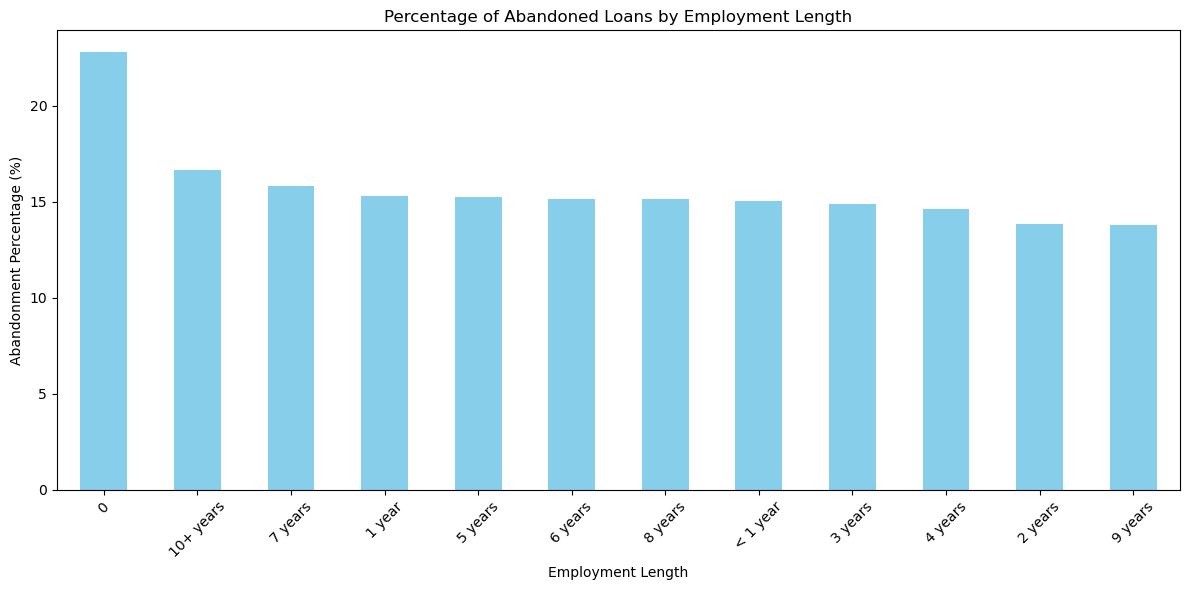

In [ ]:
abandonment_percentage = clean_data.groupby('emp_length')['abandonment'].mean() * 100

print(abandonment_percentage)

plt.figure(figsize=(12, 6))
abandonment_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Abandoned Loans by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Abandonment Percentage (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Parece ser que la cantidad de tiempo que un cliente lleva trabajando no influye mucho en el abandono, pero si el que tenga o no trabajo. Reemplacemos esta columna por un boolean 'empleo'.

In [ ]:
clean_data['employment'] = clean_data['emp_length'].apply(lambda x: 0 if x == 0 else 1)

clean_data = clean_data.drop(columns=['emp_length'])

Examinemos ahora la columna home_ownership.

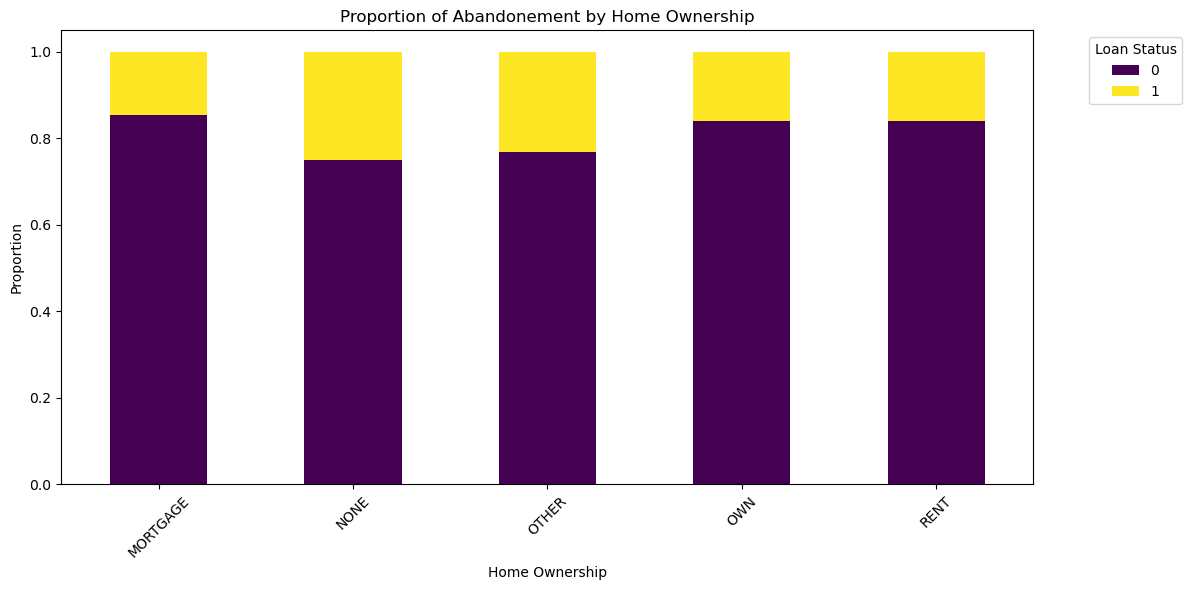

In [ ]:
home_ownership_status = clean_data.groupby(['home_ownership', 'abandonment']).size().unstack()
home_ownership_status = home_ownership_status.div(home_ownership_status.sum(axis=1), axis=0)

home_ownership_status.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Proportion of Abandonement by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Vemos que el abandono es un poco más algo en las categorías None, y Other. Entonces reemplacemos por una columna que indica inestabilidad de vivienda. Luego revisemos la relacion entre el pago al principal y al interes.

In [ ]:
clean_data['housing_instability'] = clean_data['home_ownership'].apply(lambda x: 1 if x in ['None', 'Other'] else 0)

clean_data = clean_data.drop(columns=['home_ownership'])

print(clean_data.head())

   loan_amnt  int_rate  installment  annual_inc    issue_d  \
0     2500.0     13.98        85.42     20004.0 2010-07-01   
1     5000.0     15.95       175.67     59000.0 2010-06-01   
2     7000.0      9.91       225.58     53796.0 2011-09-01   
3     2000.0      5.42        60.32     30000.0 2011-09-01   
4     3600.0     10.25       116.59    675048.0 2010-04-01   

              purpose    dti  delinq_2yrs  mths_since_last_delinq  open_acc  \
0               other  19.86          0.0                   200.0       7.0   
1  debt_consolidation  19.57          0.0                    59.0       7.0   
2               other  10.80          3.0                     3.0       7.0   
3  debt_consolidation   3.60          0.0                    72.0       7.0   
4               other   1.55          0.0                    25.0       8.0   

   ...  total_rec_prncp  total_rec_int  last_pymnt_d  last_pymnt_amnt  \
0  ...          2500.00         575.29    2013-07-01            90.85   
1  ...

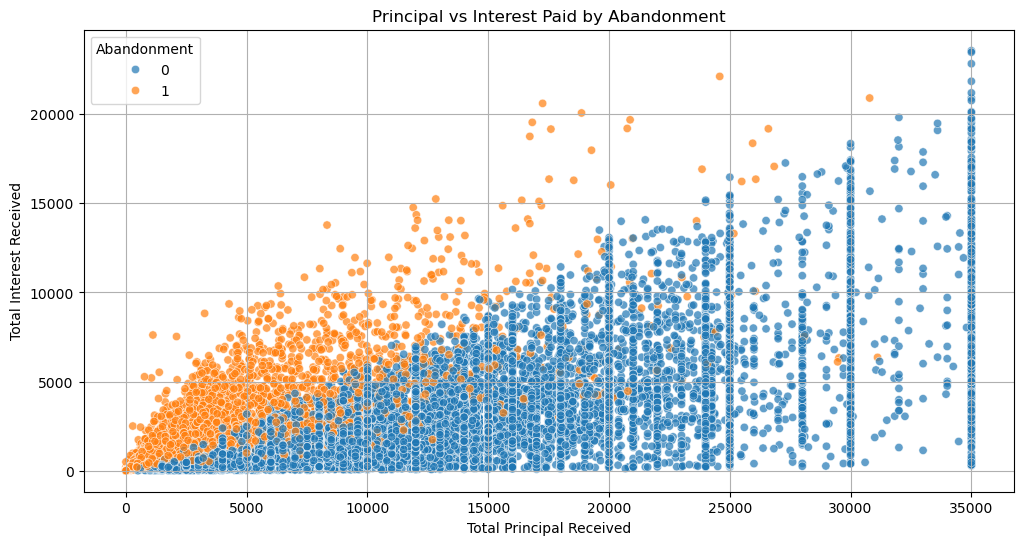

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=clean_data,
    x='total_rec_prncp',
    y='total_rec_int',
    hue='abandonment',
    alpha=0.7
)
plt.title('Principal vs Interest Paid by Abandonment')
plt.xlabel('Total Principal Received')
plt.ylabel('Total Interest Received')
plt.legend(title='Abandonment')
plt.grid(True)
plt.show()

Aquí podemos ver que -generalmente- cuando los pagos de una persona van principalmente al interés (es decir, no se percibe una reducción del monto principal), esa persona tiene más posibilidad de abandonar el préstamo.

### Aquí podríamos realizar las siguientes recomendaciones cuando el modelo detecte que un cliente tiene probabilidad de abandonar el préstamo:

1. Incrementar un poco el monto mínimo mensual.
2. Ofrecer al cliente la posibilidad de consolidar sus deudas dentro de la institución, con un interés más favorable.

Que estrategia tomar dependerá de la métrica de evaluación del modelo, y de la confianza de la predicción. Para predicciones con un nivel de confianza bajo (posibles Falsos Positivos) se recomendaría incrementar el monto mínimo mensual, ya que un cliente estable no tendría problema en pagar un 5-10% más. Se podría ofrecer una tabla de pagos comparativa para demostrar al cliente la manera en la que aumentar el pago mínimo puede pagar la deuda más rápido.

Para clientes con una alta probabilidad de abandono, se recomendaría evaluar la consolidación de deudas. Si se pueden capturar deudas de otras instituciones con tasas de interés altas, se podría ofrecer un alivio financiero al cliente, y la institución se beneficiaría del pago de interés de un monto mayor.

En base al gráfico podríamos crear una nueva columna i2p_ratio para medir la proporción del pago que ha ido hacia el interés.

In [55]:
clean_data['i2p_ratio'] = clean_data['total_rec_int'] / (clean_data['total_rec_prncp'] + 1e-5)  # Add a small value to avoid division by zero

# Transformacion logarítmica de la relación i2p
clean_data['log_i2p_ratio'] = np.log1p(clean_data['total_rec_int'] / (clean_data['total_rec_prncp'] + 1e-5))

print(clean_data[['total_rec_prncp', 'total_rec_int', 'i2p_ratio', 'log_i2p_ratio']].head())

   total_rec_prncp  total_rec_int  i2p_ratio  log_i2p_ratio
0          2500.00         575.29   0.230116       0.207108
1          1909.02         873.81   0.457727       0.376878
2          7000.00        1082.39   0.154627       0.143777
3          2000.00         161.66   0.080830       0.077729
4          3600.00         606.03   0.168342       0.155585


In [56]:
i2p_mean_by_abandonment = clean_data.groupby('abandonment')['log_i2p_ratio'].mean()
print("Mean log_i2p_ratio by abandonment:")
print(i2p_mean_by_abandonment)

correlation = clean_data['log_i2p_ratio'].corr(clean_data['abandonment'])
print(f"Correlation between log_i2p_ratio and abandonment: {correlation:.2f}")

from scipy.stats import ttest_ind

abandoned = clean_data[clean_data['abandonment'] == 1]['log_i2p_ratio']
not_abandoned = clean_data[clean_data['abandonment'] == 0]['log_i2p_ratio']

t_stat, p_value = ttest_ind(abandoned, not_abandoned, equal_var=False)
print(f"T-test results: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")

Mean log_i2p_ratio by abandonment:
abandonment
0    0.164574
1    0.452755
Name: log_i2p_ratio, dtype: float64
Correlation between log_i2p_ratio and abandonment: 0.48
T-test results: t-statistic = 49.68, p-value = 0.0000


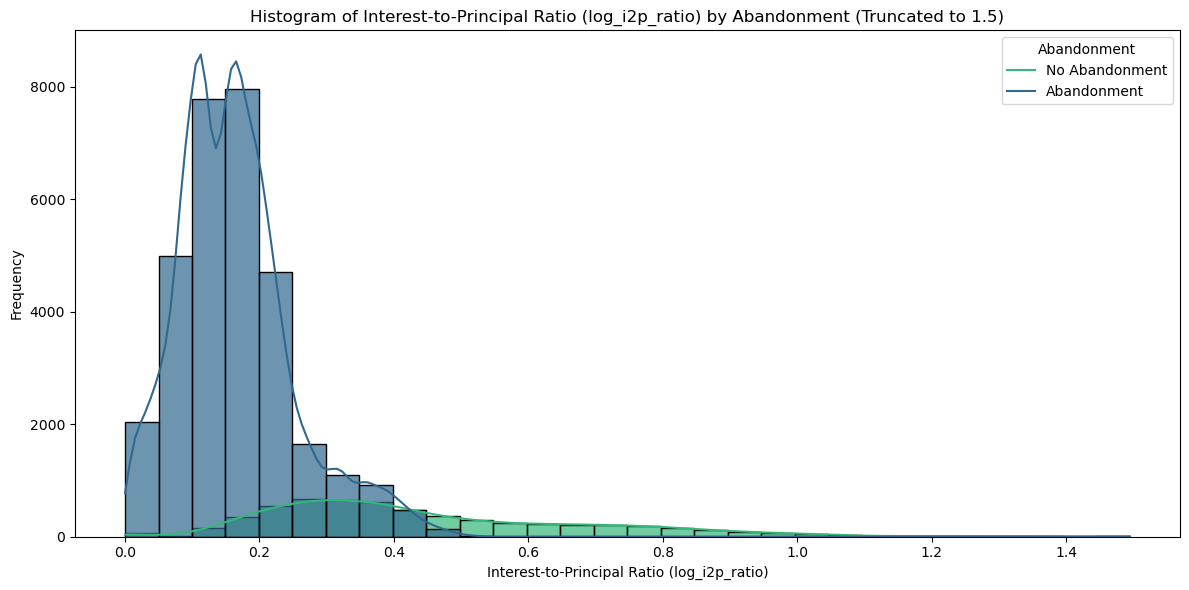

In [57]:
# Filtremos los datos para eliminar valores extremos
filtered_data = clean_data[clean_data['log_i2p_ratio'] <= 1.5]

plt.figure(figsize=(12, 6))
sns.histplot(
    data=filtered_data,
    x='log_i2p_ratio',
    hue='abandonment',
    kde=True,  
    palette='viridis',
    alpha=0.7,
    bins=30  
)
plt.title('Histogram of Interest-to-Principal Ratio (log_i2p_ratio) by Abandonment (Truncated to 1.5)')
plt.xlabel('Interest-to-Principal Ratio (log_i2p_ratio)')
plt.ylabel('Frequency')
plt.legend(title='Abandonment', labels=['No Abandonment', 'Abandonment'])
plt.tight_layout()
plt.show()

Como podemos ver gracias al t-test y al gráfico, los préstamos que se pagan tienden a tener un valor menor de i2p. Realizamos una transformación logarítmica para que los valores extremos (gente que ha pagado casi nada del principal) no influyan tanto al modelo.

In [ ]:
print("Column Info for 'log_i2p_ratio':")
print(clean_data['log_i2p_ratio'].describe())

print("\n10 Highest Values in 'log_i2p_ratio':")
print(clean_data['log_i2p_ratio'].nlargest(10))

Column Info for 'log_i2p_ratio':
count    37565.000000
mean         0.209069
std          0.217131
min          0.000000
25%          0.113016
50%          0.170174
75%          0.242459
max         17.712075
Name: log_i2p_ratio, dtype: float64

10 Highest Values in 'log_i2p_ratio':
32410    17.712075
3979     16.806733
5433     15.714479
20035     2.284067
14960     2.062762
29523     2.056028
17509     1.813499
6368      1.779986
35043     1.724572
27248     1.617866
Name: log_i2p_ratio, dtype: float64


Es recomendable deshacernos de los outliers que existen para log_i2p_ratio

In [61]:
# Eliminar valores extremos de 'log_i2p_ratio'
clean_data = clean_data[clean_data['log_i2p_ratio'] <= 2.3]
clean_data.head()

,loan_amnt,int_rate,installment,annual_inc,issue_d,purpose,dti,delinq_2yrs,mths_since_last_delinq,open_acc,...,last_pymnt_d,last_pymnt_amnt,long_term,employment_verified,time_to_delinq,abandonment,employment,housing_instability,i2p_ratio,log_i2p_ratio
0,2500.0,13.98,85.42,20004.0,2010-07-01,other,19.86,0.0,200.0,7.0,...,2013-07-01,90.85,0,0,NaN,0,1,0,0.230116,0.207108
1,5000.0,15.95,175.67,59000.0,2010-06-01,debt_consolidation,19.57,0.0,59.0,7.0,...,2011-11-01,175.67,0,0,518.0,1,1,0,0.457727,0.376878
2,7000.0,9.91,225.58,53796.0,2011-09-01,other,10.80,3.0,3.0,7.0,...,2014-03-01,1550.27,0,0,NaN,0,1,0,0.154627,0.143777
3,2000.0,5.42,60.32,30000.0,2011-09-01,debt_consolidation,3.60,0.0,72.0,7.0,...,2014-02-01,53.12,0,0,NaN,0,1,0,0.080830,0.077729
4,3600.0,10.25,116.59,675048.0,2010-04-01,other,1.55,0.0,25.0,8.0,...,2013-05-01,146.75,0,0,NaN,0,1,0,0.168342,0.155585


Ahora, creemos un nuevo dataset para entrenar nuestro modelo. Pasaremos loan_amnt, int_rate, installment, annual_inc, dti, delinq_2yrs, pub_rec, long_term, employment_verified, employment, housing_instability, log_i2p_ratio, y abandonment como nuestro target.

In [63]:
ml_columns = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
    'delinq_2yrs', 'pub_rec', 'long_term', 'employment_verified', 
    'employment', 'housing_instability', 'log_i2p_ratio', 'abandonment'
]

# Create the new dataset
ml_data = clean_data[ml_columns]

# Display the first few rows of the new dataset to verify
print(ml_data.head())

# Optionally, save the new dataset to a CSV file for future use
ml_data.to_csv('../datasets/processed_loan_data.csv', index=False)

   loan_amnt  int_rate  installment  annual_inc    dti  delinq_2yrs  pub_rec  \
0     2500.0     13.98        85.42     20004.0  19.86          0.0      0.0   
1     5000.0     15.95       175.67     59000.0  19.57          0.0      0.0   
2     7000.0      9.91       225.58     53796.0  10.80          3.0      0.0   
3     2000.0      5.42        60.32     30000.0   3.60          0.0      0.0   
4     3600.0     10.25       116.59    675048.0   1.55          0.0      0.0   

   long_term  employment_verified  employment  housing_instability  \
0          0                    0           1                    0   
1          0                    0           1                    0   
2          0                    0           1                    0   
3          0                    0           1                    0   
4          0                    0           1                    0   

   log_i2p_ratio  abandonment  
0       0.207108            0  
1       0.376878            1  
2 